## In this file, I create holdback set with single posts.
## Resources
[NLTK][https://stackabuse.com/text-classification-with-python-and-scikit-learn/]

In [1]:
import nltk
import pickle
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score, precision_score, classification_report, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# nltk.download('stopwords')
# nltk.download('wordnet')

In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [3]:
train_size = 0.8
vectorizer_max_features = 1500
chosen_classifier = MultinomialNB

In [4]:
from functions import load_data_set
myers_briggs = load_data_set()

In [5]:
mb_df = pd.DataFrame(myers_briggs, columns=['type', 'posts'])
types = sorted(mb_df['type'].unique())

post_list = [re.split('\|\|\|+', post) for post in mb_df['posts']]
post_df = pd.DataFrame(post_list)
post_df.insert(loc=0, column='type', value=mb_df['type'])

posts_by_type = {typ: mb_df[mb_df['type'] == typ] for typ in types}

In [6]:
vertical_post_df = pd.read_csv('vertical_posts.csv', index_col=0)

## Split personalities into components.

In [7]:
mb_df['EI'] = mb_df['type'].apply(lambda x: x[0])
mb_df['NS'] = mb_df['type'].apply(lambda x: x[1])
mb_df['FT'] = mb_df['type'].apply(lambda x: x[2])
mb_df['JP'] = mb_df['type'].apply(lambda x: x[3])

EI_df = mb_df[['EI', 'posts']]
NS_df = mb_df[['NS', 'posts']]
FT_df = mb_df[['FT', 'posts']]
JP_df = mb_df[['JP', 'posts']]

In [8]:
X, y = EI_df['posts'], EI_df['EI']
# X, y = vertical_post_df['posts'], vertical_post_df['type']

## Might want to remove URLs

In [9]:
X_train_val, X_holdback, y_train_val, y_holdback = train_test_split(X, y)

In [10]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X_train_val)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X_train_val.iloc[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [11]:
vectorizer = CountVectorizer(max_features=vectorizer_max_features, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X_train_val).toarray()

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train_val, train_size=train_size, random_state=0)

In [14]:
# classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier = chosen_classifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  5 298]
 [  1 998]]
              precision    recall  f1-score   support

           E       0.83      0.02      0.03       303
           I       0.77      1.00      0.87       999

    accuracy                           0.77      1302
   macro avg       0.80      0.51      0.45      1302
weighted avg       0.78      0.77      0.67      1302

0.7703533026113671


In [16]:
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(classifier,picklefile)

In [17]:
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

In [18]:
y_pred2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
print(accuracy_score(y_test, y_pred2)) 

[[  5 298]
 [  1 998]]
              precision    recall  f1-score   support

           E       0.83      0.02      0.03       303
           I       0.77      1.00      0.87       999

    accuracy                           0.77      1302
   macro avg       0.80      0.51      0.45      1302
weighted avg       0.78      0.77      0.67      1302

0.7703533026113671


In [19]:
print(chosen_classifier, vectorizer_max_features, train_size)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Precision:", precision_score(y_test, y_pred2, average='micro'))
print("Precision:", precision_score(y_test, y_pred2, average=None))
cr = classification_report(y_test, y_pred2)
cr.split('\n')

<class 'sklearn.naive_bayes.MultinomialNB'> 1500 0.8
Accuracy: 0.7703533026113671
Precision: 0.7703533026113671
Precision: [0.83333333 0.77006173]


['              precision    recall  f1-score   support',
 '',
 '           E       0.83      0.02      0.03       303',
 '           I       0.77      1.00      0.87       999',
 '',
 '    accuracy                           0.77      1302',
 '   macro avg       0.80      0.51      0.45      1302',
 'weighted avg       0.78      0.77      0.67      1302',
 '']

## ROC

ROC AUC score =  0.8256044823701589


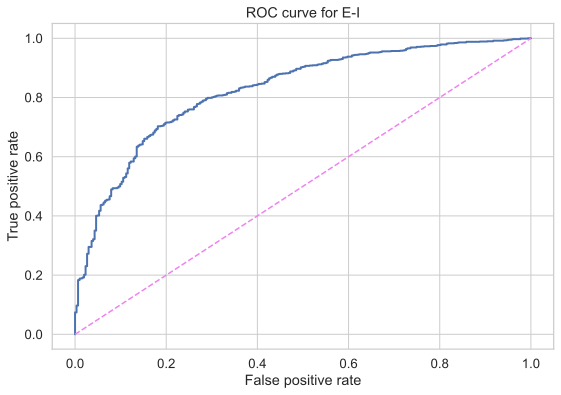

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1], pos_label='I')

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for E-I');
print("ROC AUC score = ", roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))


In [ ]:
## Run model on verticalized holdbacks## Run model on verticalized holdbacks## Run model on verticalized holdbacks


## Run model on verticalized holdbacks

In [27]:
holdback_df = pd.DataFrame(zip(y_holdback, X_holdback), columns=('type', 'posts'))

In [28]:
holdback_post_list = [re.split('\|\|\|+', post) for post in holdback_df['posts']]
holdback_post_df = pd.DataFrame(holdback_post_list)
holdback_post_df.insert(loc=0, column='type', value=holdback_df['type'])

In [29]:
# Splits posts of holdback set into single posts.
def compress_posts(df):
    result = []
    df_length = range(len(df))

    for i in df_length:
        for j in range(58):
            if df.iloc[i][j] != None:
                result.append([df['type'][i], df.iloc[i][j]])
    
    return pd.DataFrame(result, columns=('type', 'post'))

vertical_holdback = compress_posts(holdback_post_df)

In [30]:
# sanitize and vectorize
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(vertical_holdback)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(vertical_holdback['post'][sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [31]:
vertical_X_holdback = vectorizer.transform(documents).toarray()
vertical_X_holdback = tfidfconverter.fit_transform(vertical_X_holdback).toarray()
pred_holdback = classifier.predict(vertical_X_holdback)

In [32]:
print(chosen_classifier, vectorizer_max_features, train_size)

print("Accuracy:", accuracy_score(vertical_holdback['type'], pred_holdback))
print("Precision:", precision_score(vertical_holdback['type'], pred_holdback, average='micro'))
print("Precision:", precision_score(vertical_holdback['type'], pred_holdback, average=None))
cr = classification_report(vertical_holdback['type'], pred_holdback)
cr.split('\n')

<class 'sklearn.naive_bayes.MultinomialNB'> 1500 0.8
Accuracy: 0.7637171340512157
Precision: 0.7637171340512157
Precision: [0.464      0.76407394]


['              precision    recall  f1-score   support',
 '',
 '           E       0.46      0.00      0.00     24830',
 '           I       0.76      1.00      0.87     80294',
 '',
 '    accuracy                           0.76    105124',
 '   macro avg       0.61      0.50      0.44    105124',
 'weighted avg       0.69      0.76      0.66    105124',
 '']

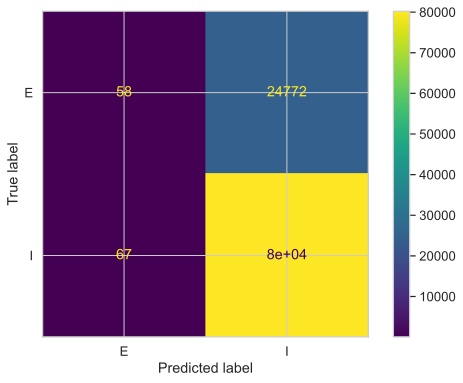

In [33]:
plot_confusion_matrix(classifier, vertical_X_holdback, vertical_holdback['type'])

In [34]:
classifier.predict_proba(vertical_X_holdback)

array([[0.22597439, 0.77402561],
       [0.18781102, 0.81218898],
       [0.18829174, 0.81170826],
       ...,
       [0.21832512, 0.78167488],
       [0.29823104, 0.70176896],
       [0.1934957 , 0.8065043 ]])

ROC AUC score =  0.8256044823701589


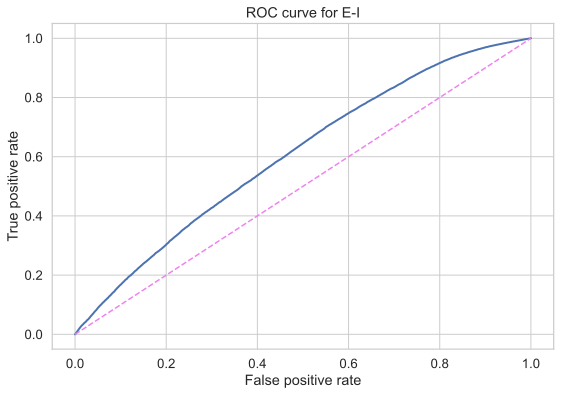

In [35]:
fpr, tpr, thresholds = roc_curve(vertical_holdback['type'], classifier.predict_proba(vertical_X_holdback)[:,1], pos_label='I')

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for E-I');
print("ROC AUC score = ", roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]))